In [ ]:
# try the blending with just the match
# blending-parameter vs total-mass
# phenD vs eobv2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import datetime

from tqdm.notebook import tqdm


import lal
import lalsimulation as lalsim

import pycbc.waveform
import pycbc.pnutils
import pycbc.waveform.utils as wfutils
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
import pycbc.types

# quick example

In [2]:
def generate_and_match(mass1, mass2, spin1z, spin2z, f_lower, delta_t, approx1, approx2, genfun1, genfun2):
    hp = {}
    hp[approx1], _ = genfun1(approximant=approx1, mass1=mass1, mass2=mass2, spin1z=spin1z, spin2z=spin2z, f_lower=f_lower, delta_t=delta_t)
    hp[approx2], _ = genfun2(approximant=approx2, mass1=mass1, mass2=mass2, spin1z=spin1z, spin2z=spin2z, f_lower=f_lower, delta_t=delta_t)

    hp_aligned = {}
    hp_aligned[approx1], hp_aligned[approx2] = wfutils.coalign_waveforms(hp[approx1], hp[approx2])
    
    plt.figure(figsize=(18, 6))
    plt.plot(hp_aligned[approx1].sample_times, hp_aligned[approx1], label=approx1)
    plt.plot(hp_aligned[approx2].sample_times, hp_aligned[approx2], label=approx2)
    plt.legend()
    plt.xlim(-0.4, 0.1)
#     plt.xlim(-0.2, 0.1)

    tlen = max(len(hp[approx1]), len(hp[approx2]))
    hp[approx1].resize(tlen)
    hp[approx2].resize(tlen)
    
    # Generate the aLIGO ZDHP PSD
    f_low = f_lower
    delta_f = 1.0 / hp[approx1].duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    m, i = match(hp[approx1], hp[approx2], psd=psd, low_frequency_cutoff=f_low)
    print('The match is: {:.4f}'.format(m))

In [3]:
params = dict(mass1=80, mass2=20, spin1z=0.9, spin2z=0.9, f_lower=20., delta_t=1/4096.)

The match is: 0.7639


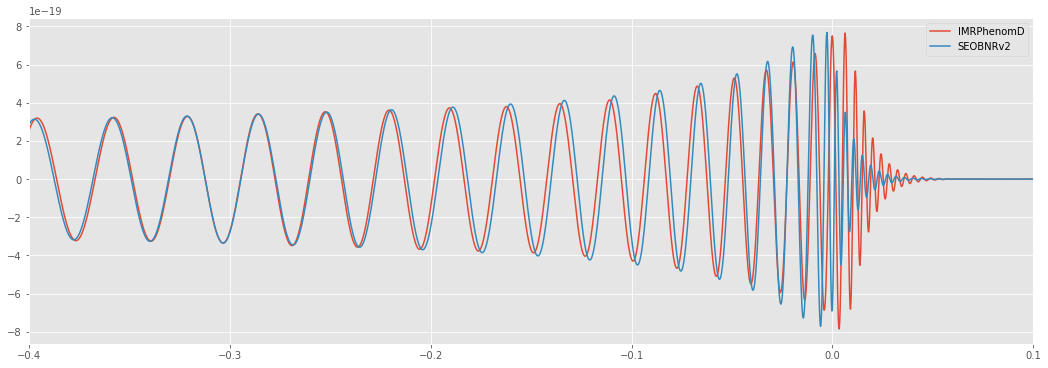

In [4]:
params.update({'approx1':"IMRPhenomD", 'genfun1':pycbc.waveform.get_td_waveform_from_fd, 'approx2':"SEOBNRv2", 'genfun2':pycbc.waveform.get_td_waveform})
generate_and_match(**params)

In [5]:
params.update({'approx1':"SEOBNRv2", 'genfun1':pycbc.waveform.get_td_waveform, 'approx2':"SEOBNRv4", 'genfun2':pycbc.waveform.get_td_waveform})
generate_and_match(**params)

The match is: 0.6953


The match is: 0.9673


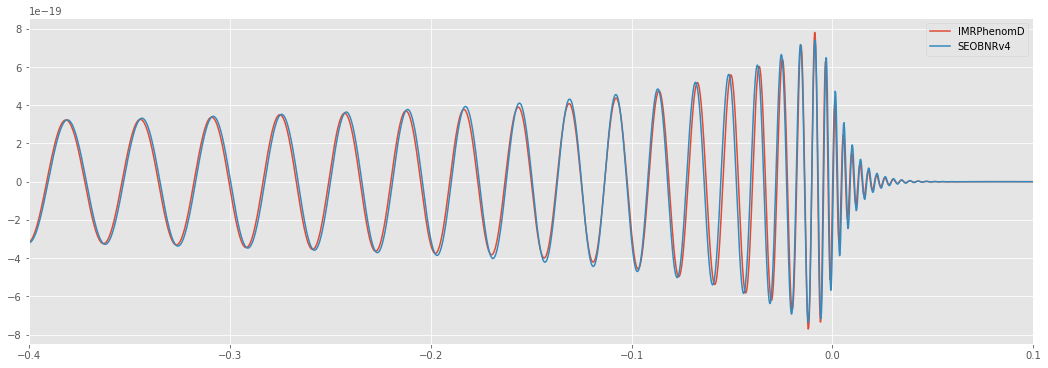

In [6]:
params.update({'approx1':"IMRPhenomD", 'genfun1':pycbc.waveform.get_td_waveform, 'approx2':"SEOBNRv4", 'genfun2':pycbc.waveform.get_td_waveform})
generate_and_match(**params)

# blended waveforms

In [7]:
def plus_and_cross_coalign_waveforms(h1_p, h1_c, h2_p, h2_c, psd=None,
                      low_frequency_cutoff=None,
                      high_frequency_cutoff=None,
                      resize=True):
    """ 
    coalign both plus and cross
    """
    from pycbc.filter import matched_filter
    mlen = wfutils.ceilpow2(max(len(h1_p), len(h2_p)))

    h1_p = h1_p.copy()
    h1_c = h1_c.copy()
    h2_p = h2_p.copy()
    h2_c = h2_c.copy()

    if resize:
        h1_p.resize(mlen)
        h2_p.resize(mlen)
        h1_c.resize(mlen)
        h2_c.resize(mlen)
    elif len(h1_p) != len(h2_p) or len(h2_p) % 2 != 0:
        raise ValueError("Time series must be the same size and even if you do "
                         "not allow resizing")

    snr = matched_filter(h1_p, h2_p, psd=psd,
                         low_frequency_cutoff=low_frequency_cutoff,
                         high_frequency_cutoff=high_frequency_cutoff)

    _, l =  snr.abs_max_loc()
    rotation =  snr[l] / abs(snr[l])
    h1_p = (h1_p.to_frequencyseries() * rotation).to_timeseries()
    h1_p.roll(l)
    
    h1_c = (h1_c.to_frequencyseries() * rotation).to_timeseries()
    h1_c.roll(l)

    h1_p = pycbc.types.TimeSeries(h1_p, delta_t=h2_p.delta_t, epoch=h2_p.start_time)
    h1_c = pycbc.types.TimeSeries(h1_c, delta_t=h2_c.delta_t, epoch=h2_c.start_time)
    return h1_p, h1_c, h2_p, h2_c

In [8]:
def generate_blended_waveform(alphas, mass1, mass2, spin1z, spin2z, f_lower, delta_t, approx1, approx2, genfun1, genfun2):
    """
    alphas:, array,  blending factor: h*(1-alpha) + h*(alpha)
    """
    hp = {}
    hc = {}
    hp[approx1], hc[approx1] = genfun1(approximant=approx1, mass1=mass1, mass2=mass2, spin1z=spin1z, spin2z=spin2z, f_lower=f_lower, delta_t=delta_t)
    hp[approx2], hc[approx2] = genfun2(approximant=approx2, mass1=mass1, mass2=mass2, spin1z=spin1z, spin2z=spin2z, f_lower=f_lower, delta_t=delta_t)

    hp_aligned = {}
    hc_aligned = {}
    
    hp_aligned[approx1], hc_aligned[approx1], hp_aligned[approx2], hc_aligned[approx2] = plus_and_cross_coalign_waveforms(hp[approx1], hc[approx1], hp[approx2], hc[approx2])
    
#     plt.figure(figsize=(18, 6))
#     plt.subplot(2, 1, 1)
#     plt.plot(hp_aligned[approx1].sample_times, hp_aligned[approx1], label=approx1)
#     plt.plot(hp_aligned[approx2].sample_times, hp_aligned[approx2], label=approx2)
#     plt.legend()
#     plt.xlim(-0.4, 0.1)
# #     plt.xlim(-0.2, 0.1)
#     plt.title('hp')

#     plt.subplot(2, 1, 2)
#     plt.plot(hc_aligned[approx1].sample_times, hc_aligned[approx1], label=approx1)
#     plt.plot(hc_aligned[approx2].sample_times, hc_aligned[approx2], label=approx2)
#     plt.legend()
#     plt.xlim(-0.4, 0.1)
#     plt.title('hc')
    
    amp = {}
    amp[approx1] = wfutils.amplitude_from_polarizations(hp_aligned[approx1], hc_aligned[approx1])
    amp[approx2] = wfutils.amplitude_from_polarizations(hp_aligned[approx2], hc_aligned[approx2])

    phase = {}
    phase[approx1] = wfutils.phase_from_polarizations(hp_aligned[approx1], hc_aligned[approx1])
    phase[approx2] = wfutils.phase_from_polarizations(hp_aligned[approx2], hc_aligned[approx2])
    
    amp_blends = [amp[approx1].numpy() * (1-alpha) + amp[approx2].numpy() * (alpha) for alpha in alphas]
    phase_blends = [phase[approx1].numpy() * (1-alpha) + phase[approx2].numpy() * (alpha) for alpha in alphas]
    
    amp_blends = [pycbc.types.TimeSeries(amp_blend, delta_t=amp[approx1].delta_t, epoch=amp[approx1].start_time) for amp_blend in amp_blends]
    phase_blends = [pycbc.types.TimeSeries(phase_blend, delta_t=amp[approx1].delta_t, epoch=amp[approx1].start_time) for phase_blend in phase_blends]
    
    plt.figure(figsize=(18, 6))
    plt.plot(amp[approx1].sample_times, amp[approx1], label=approx1, lw=4)
    plt.plot(amp[approx2].sample_times, amp[approx2], label=approx2, lw=4)
    for i, amp_blend in enumerate(amp_blends):
        plt.plot(amp_blend.sample_times, amp_blend, label=f'blended: {alphas[i]}')
    plt.xlim(-0.1, 0.1)
#     plt.legend()
    plt.title('amp')    
    plt.show()
    plt.close()
    
    plt.figure(figsize=(18, 6))
    plt.plot(phase[approx1].sample_times, phase[approx1], label=approx1, lw=4)
    plt.plot(phase[approx2].sample_times, phase[approx2], label=approx2, lw=4)
    for i, phase_blend in enumerate(phase_blends):
        plt.plot(phase_blend.sample_times, phase_blend, label=f'blended: {alphas[i]}')
    plt.xlim(-0.1, 0.03)
    plt.ylim(150, 400)
#     plt.legend()
    plt.title('phase')
    plt.show()
    plt.close()
    
    h_complex_blends = [amp_blends[i].numpy()*np.exp(1.j*phase_blends[i].numpy()) for i in range(len(alphas))]
    
    hp_blends = [pycbc.types.TimeSeries(np.real(h_complex_blend), delta_t=amp[approx1].delta_t, epoch=amp[approx1].start_time) for h_complex_blend in h_complex_blends]
    hc_blends = [pycbc.types.TimeSeries(np.imag(h_complex_blend), delta_t=amp[approx1].delta_t, epoch=amp[approx1].start_time) for h_complex_blend in h_complex_blends]
    
#     plt.figure(figsize=(18, 6))
#     plt.plot(hp_aligned[approx1].sample_times, hp_aligned[approx1], label=approx1, lw=4)
#     plt.plot(hp_aligned[approx2].sample_times, hp_aligned[approx2], label=approx2, lw=4)
#     for i, hp_blend in enumerate(hp_blends):
#         plt.plot(hp_blend.sample_times, hp_blend, label=f'blended: {alphas[i]}')
#     plt.xlim(-0.1, 0.03)
# #     plt.ylim(150, 400)
#     plt.legend()
#     plt.title('hp blended')
#     plt.show()
#     plt.close()
    
#     phi_test = wfutils.phase_from_polarizations(hp_blends[0], hc_blends[0])
#     plt.figure()
#     plt.plot(phi_test.sample_times, phi_test)
    
    
#     h1, h2 = wfutils.coalign_waveforms(hp_aligned[approx1], hp_blends[0])
#     plt.figure()
#     plt.plot(h1.sample_times, h1)
#     plt.plot(h2.sample_times, h2, ls='--')
#     plt.xlim(-0.1, 0.2)
#     plt.show()
#     plt.close()
    
    
#     h1, h2 = wfutils.coalign_waveforms(hc_aligned[approx1], hc_blends[0])
#     plt.figure()
#     plt.plot(h1.sample_times, h1)
#     plt.plot(h2.sample_times, h2, ls='--')
#     plt.xlim(-0.1, 0.2)
#     plt.show()
#     plt.close()

    h_true = {
        approx1:{'hp':hp_aligned[approx1], 'hc':hc_aligned[approx1]},
        approx2:{'hp':hp_aligned[approx2], 'hc':hc_aligned[approx2]}
    }

    return hp_blends, hc_blends, h_true

In [9]:
def compute_match_list(signal, templates, f_lower):
    
    tlen = max(len(signal), len(templates[0]))
    signal.resize(tlen)
    for template in templates:
        template.resize(tlen)
    
    # Generate the aLIGO ZDHP PSD
    f_low = f_lower
    delta_f = 1.0 / signal.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    matches = []
    for i, template in enumerate(templates):
        tmp_m, _ = match(signal, template, psd=psd, low_frequency_cutoff=f_low)
        matches.append(tmp_m)
        
    return matches


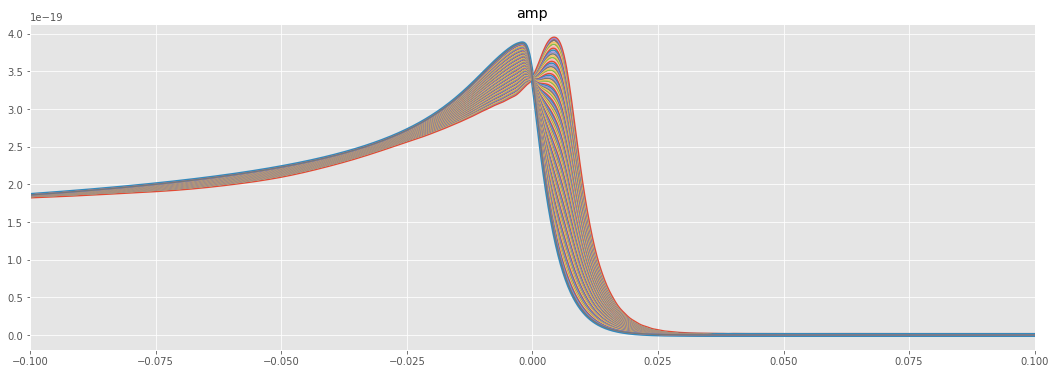

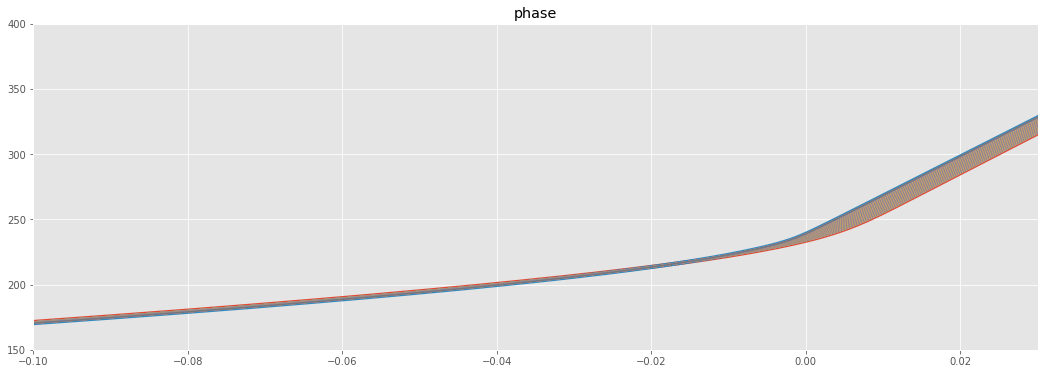

In [10]:
alphas = np.linspace(0, 1, 100)
# alphas = [0]
params = dict(alphas=alphas, mass1=40, mass2=10, spin1z=0.9, spin2z=0.9, f_lower=30., delta_t=1/4096.)
params.update({'approx1':"IMRPhenomD", 'genfun1':pycbc.waveform.get_td_waveform_from_fd, 'approx2':"SEOBNRv2", 'genfun2':pycbc.waveform.get_td_waveform})
hp_blends, hc_blends, h_true = generate_blended_waveform(**params)

In [11]:
params

{'alphas': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.7272

In [12]:
h_true[params['approx1']]

{'hp': <pycbc.types.timeseries.TimeSeries at 0x1a350c9810>,
 'hc': <pycbc.types.timeseries.TimeSeries at 0x1a350c93d0>}

In [13]:
matches = compute_match_list(signal=h_true[params['approx2']]['hp'], templates=hp_blends, f_lower=20)

In [14]:
matches = compute_match_list(signal=hp_blends[50], templates=hp_blends, f_lower=20)

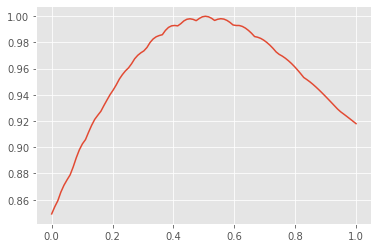

In [15]:
plt.figure()
plt.plot(params['alphas'], matches, '-')

# refine blended waveform function

In [16]:
def generate_blended_waveform_single(alpha, mass1, mass2, spin1z, spin2z, f_lower, delta_t, approx1, approx2, genfun1, genfun2):
    """
    alpha1:, float,  blending factor: h*(1-alpha) + h*(alpha)
    """
    hp = {}
    hc = {}
    hp[approx1], hc[approx1] = genfun1(approximant=approx1, mass1=mass1, mass2=mass2, spin1z=spin1z, spin2z=spin2z, f_lower=f_lower, delta_t=delta_t)
    hp[approx2], hc[approx2] = genfun2(approximant=approx2, mass1=mass1, mass2=mass2, spin1z=spin1z, spin2z=spin2z, f_lower=f_lower, delta_t=delta_t)

    hp_aligned = {}
    hc_aligned = {}
    
    hp_aligned[approx1], hc_aligned[approx1], hp_aligned[approx2], hc_aligned[approx2] = plus_and_cross_coalign_waveforms(hp[approx1], hc[approx1], hp[approx2], hc[approx2])
    
    amp = {}
    amp[approx1] = wfutils.amplitude_from_polarizations(hp_aligned[approx1], hc_aligned[approx1])
    amp[approx2] = wfutils.amplitude_from_polarizations(hp_aligned[approx2], hc_aligned[approx2])

    phase = {}
    phase[approx1] = wfutils.phase_from_polarizations(hp_aligned[approx1], hc_aligned[approx1])
    phase[approx2] = wfutils.phase_from_polarizations(hp_aligned[approx2], hc_aligned[approx2])
    
    amp_blend = amp[approx1].numpy() * (1-alpha) + amp[approx2].numpy() * (alpha)
    phase_blend = phase[approx1].numpy() * (1-alpha) + phase[approx2].numpy() * (alpha)
    
    amp_blend = pycbc.types.TimeSeries(amp_blend, delta_t=amp[approx1].delta_t, epoch=amp[approx1].start_time)
    phase_blend = pycbc.types.TimeSeries(phase_blend, delta_t=amp[approx1].delta_t, epoch=amp[approx1].start_time)
    
    h_complex_blend = amp_blend.numpy()*np.exp(1.j*phase_blend.numpy())
    
    hp_blend = pycbc.types.TimeSeries(np.real(h_complex_blend), delta_t=amp[approx1].delta_t, epoch=amp[approx1].start_time)
    hc_blend = pycbc.types.TimeSeries(np.imag(h_complex_blend), delta_t=amp[approx1].delta_t, epoch=amp[approx1].start_time)

    return hp_blend, hc_blend

In [17]:
alpha = 0.5
params = dict(alpha=alpha, mass1=40, mass2=10, spin1z=0.9, spin2z=0.9, f_lower=30., delta_t=1/4096.)
params.update({'approx1':"IMRPhenomD", 'genfun1':pycbc.waveform.get_td_waveform_from_fd, 'approx2':"SEOBNRv2", 'genfun2':pycbc.waveform.get_td_waveform})
hp_blend, hc_blend = generate_blended_waveform_single(**params)

In [18]:
hp_blend

(-0.5, 0.1)

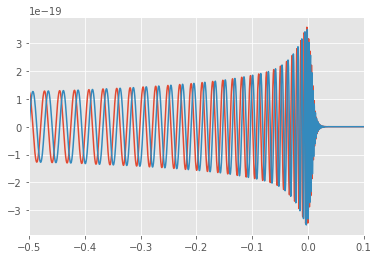

In [19]:
plt.figure()
plt.plot(hp_blend.sample_times, hp_blend)
plt.plot(hc_blend.sample_times, hc_blend)
plt.xlim(-0.5, 0.1)

# matches vs total mass

In [5]:
import phenom

In [6]:
def compute_match(signal, template, f_lower):
    tlen = max(len(signal), len(template))
    signal.resize(tlen)
    template.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    f_low = f_lower
    delta_f = 1.0 / signal.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    m, _ = match(signal, template, psd=psd, low_frequency_cutoff=f_low)
    return m

In [7]:
def compute_loglikelihood(signal, template, f_lower, snr):
    """
    equation 2.3 1512.04955
    """
    tlen = max(len(signal), len(template))
    signal.resize(tlen)
    template.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    f_low = f_lower
    delta_f = 1.0 / signal.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    m, _ = match(signal, template, psd=psd, low_frequency_cutoff=f_low)
    
#     likelihood = np.exp(0.5*snr**2*m**2)
    loglikelihood = 0.5*snr**2*m**2
    
    return loglikelihood

In [8]:
def matches_vs_total_mass():
    snr = 50
    delta_t = 1/4096.
    f_lower = 20.
    
    mtot_true = 100
    q_true = 4
    mass1_true, mass2_true = phenom.m1_m2_M_q(mtot_true, q_true)
    spin1z_true = 0.9
    spin2z_true = 0.9
    signal_hp, _ = pycbc.waveform.get_td_waveform(approximant="SEOBNRv4", mass1=mass1_true, mass2=mass2_true, spin1z=spin1z_true, spin2z=spin2z_true, f_lower=f_lower, delta_t=delta_t)
    
    # create grid
    n_m = 10
    n_a = 10
    mtot_grid = np.linspace(80, 120, n_m)
    alpha_grid = np.linspace(0, 1, n_a)
    _mtots, _alphas = np.meshgrid(mtot_grid, alpha_grid)
    _mtots_1d = _mtots.ravel()
    _alphas_1d = _alphas.ravel()
    
#     matches = np.zeros(shape = _mtots_1d.shape)
    loglikelihood = np.zeros(shape = _mtots_1d.shape)
    for i in tqdm(range(len(matches))):
        alpha = _alphas_1d[i]
        mtot = _mtots_1d[i]
        m1, m2 = phenom.m1_m2_M_q(mtot, q_true)
        params = dict(alpha=alpha, mass1=m1, mass2=m2, spin1z=spin1z_true, spin2z=spin2z_true, f_lower=f_lower, delta_t=delta_t)
        params.update({'approx1':"IMRPhenomD", 'genfun1':pycbc.waveform.get_td_waveform_from_fd, 'approx2':"SEOBNRv2", 'genfun2':pycbc.waveform.get_td_waveform})
        hp_blend, hc_blend = generate_blended_waveform_single(**params)

#         matches[i] = compute_match(signal_hp, hp_blend, f_lower)
        loglikelihood[i] = compute_loglikelihood(signal_hp, hp_blend, f_lower, snr)
        
    return _mtots, _alphas, loglikelihood.reshape((n_m, n_a))

In [32]:
_mtots, _alphas, matches = matches_vs_total_mass()

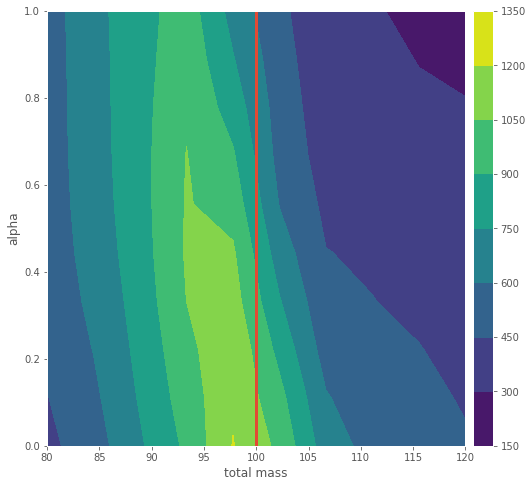

In [34]:
plt.figure(figsize=(8,8))
cs = plt.contourf(_mtots, _alphas, matches)
plt.xlabel("total mass")
plt.ylabel("alpha")
plt.axvline(100, lw=3)


from mpl_toolkits.axes_grid1 import make_axes_locatable
# https://stackoverflow.com/questions/29516157/set-equal-aspect-in-plot-with-colorbar
the_divider = make_axes_locatable(plt.gca())
color_axis = the_divider.append_axes("right", size="5%", pad=0.1)
# plt.colorbar(cs, ticks=np.linspace(matches.min(), 1, 11), cax=color_axis)
plt.colorbar(cs, cax=color_axis)

# try again

In [21]:
def matches_vs_total_mass_2():
    snr = 50
    delta_t = 1/4096.
    f_lower = 20.
    
    mtot_true = 100
    q_true = 4
    mass1_true, mass2_true = phenom.m1_m2_M_q(mtot_true, q_true)
    spin1z_true = 0.9
    spin2z_true = 0.9
    signal_hp, _ = pycbc.waveform.get_td_waveform(approximant="SEOBNRv4", mass1=mass1_true, mass2=mass2_true, spin1z=spin1z_true, spin2z=spin2z_true, f_lower=f_lower, delta_t=delta_t)
    
    # create grid
    n_m = 30
    n_a = 30
    mtot_grid = np.linspace(80, 120, n_m)
    
    matches_approx = {}
    
    approxs = ["IMRPhenomD", "SEOBNRv2"]
    for approx in tqdm(approxs):
        matches_approx[approx] = []
        for mtot in tqdm(mtot_grid):
            m1, m2 = phenom.m1_m2_M_q(mtot, q_true)
            hp_approx, _ = pycbc.waveform.get_td_waveform(approximant=approx, mass1=m1, mass2=m2, spin1z=spin1z_true, spin2z=spin2z_true, f_lower=f_lower, delta_t=delta_t)
#             matches_approx[approx].append(compute_match(signal_hp, hp_approx, f_lower))
            matches_approx[approx].append(compute_loglikelihood(signal_hp, hp_approx, f_lower, snr))
    

    alpha_grid = np.linspace(0, 1, n_a)
    _mtots, _alphas = np.meshgrid(mtot_grid, alpha_grid)
    _mtots_1d = _mtots.ravel()
    _alphas_1d = _alphas.ravel()
    
    matches = np.zeros(shape = _mtots_1d.shape)
    for i in tqdm(range(len(matches))):
        alpha = _alphas_1d[i]
        mtot = _mtots_1d[i]
        m1, m2 = phenom.m1_m2_M_q(mtot, q_true)
        params = dict(alpha=alpha, mass1=m1, mass2=m2, spin1z=spin1z_true, spin2z=spin2z_true, f_lower=f_lower, delta_t=delta_t)
        params.update({'approx1':"IMRPhenomD", 'genfun1':pycbc.waveform.get_td_waveform_from_fd, 'approx2':"SEOBNRv2", 'genfun2':pycbc.waveform.get_td_waveform})
        hp_blend, hc_blend = generate_blended_waveform_single(**params)

#         matches[i] = compute_match(signal_hp, hp_blend, f_lower)
        matches[i] = compute_loglikelihood(signal_hp, hp_blend, f_lower, snr)
        
    return mtot_grid, matches_approx, _mtots, _alphas, matches.reshape((n_m, n_a))
#     return mtot_grid, matches_approx, _mtots, _alphas

In [22]:
# %%time
# mtot_grid, matches2, _mtots, _alphas, matches_alpha_grid  = matches_vs_total_mass_2()
# mtot_grid, matches2, _mtots, _alphas  = matches_vs_total_mass_2()



CPU times: user 7.51 s, sys: 87 ms, total: 7.6 s
Wall time: 7.6 s


In [9]:
# np.save("_mtot_grid.npy", mtot_grid)
# np.save("_matches2.npy", matches2)

mtot_grid = np.load("_mtot_grid.npy")
matches2 = np.load("_matches2.npy", allow_pickle=True).flat[0]

In [10]:
# np.save("_mtots.npy", _mtots)
# np.save("_alphas.npy", _alphas)
# np.save("matches_alpha_grid.npy", matches_alpha_grid)

_mtots = np.load("_mtots.npy")
_alphas = np.load("_alphas.npy")
matches_alpha_grid = np.load("matches_alpha_grid.npy")

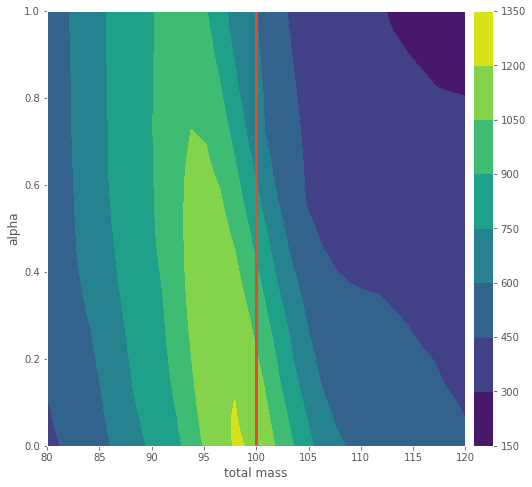

In [11]:
plt.figure(figsize=(8,8))
cs = plt.contourf(_mtots, _alphas, matches_alpha_grid)
plt.xlabel("total mass")
plt.ylabel("alpha")
plt.axvline(100, lw=3)



from mpl_toolkits.axes_grid1 import make_axes_locatable
# https://stackoverflow.com/questions/29516157/set-equal-aspect-in-plot-with-colorbar
the_divider = make_axes_locatable(plt.gca())
color_axis = the_divider.append_axes("right", size="5%", pad=0.1)
# plt.colorbar(cs, ticks=np.linspace(matches.min(), 1, 11), cax=color_axis)
plt.colorbar(cs, cax=color_axis)

In [ ]:
# integrand = np.exp(logL - logL.max()) * d_alpha
# logL_marg = np.log(integrand.sum()) + logL.max()

In [12]:
res = np.zeros(matches_alpha_grid.shape)
ii, jj = matches_alpha_grid.shape
for i in range(ii):
    for j in range(jj):
        res[i,j] = matches_alpha_grid[i,j] * _alphas[i,j] 
res = res.sum(axis=0)

In [17]:
matches_alpha_grid.max()

1207.2200864520996

In [18]:
# franks scaling idea working well

# res2 = matches_alpha_grid * 0.03448276 #*_alphas
res2 = np.exp(matches_alpha_grid-matches_alpha_grid.max()) * 0.03448276 #*_alphas
res2 = np.log(res2.sum(axis=0)) + matches_alpha_grid.max()

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
res

array([ 7808.18118286,  8364.14827341,  9077.84979405,  9925.14352879,
       10871.19445455, 11624.38509623, 12249.98800349, 12974.28798323,
       13936.09198397, 14945.63058474, 15586.65898217, 15543.42336084,
       14745.79164917, 13318.12778934, 11742.20795259, 10331.74085689,
        8951.66058636,  7740.55433769,  6756.1812487 ,  6080.18983689,
        5913.04931235,  5843.27466216,  5748.49274031,  5601.49785797,
        5442.61479814,  5268.5791343 ,  5111.32982574,  4988.52584852,
        4906.7111724 ,  4846.11593455])

In [20]:
res2

array([ 528.43994278,  567.08598733,  623.36608376,  688.97203965,
        743.77709849,  787.24671301,  827.28061876,  874.52288761,
        944.35009904, 1017.10816138, 1085.46066392, 1140.53116084,
       1181.19020165, 1204.55252424, 1192.95540966, 1127.70188767,
       1024.97723185,  907.1116071 ,  793.28542624,  696.79317544,
        626.22840081,  581.23423029,  554.73675226,  538.21772654,
        525.12638138,  512.03915483,  498.21376229,  484.39287351,
        474.31098618,          -inf])

Text(0, 0.5, 'match')

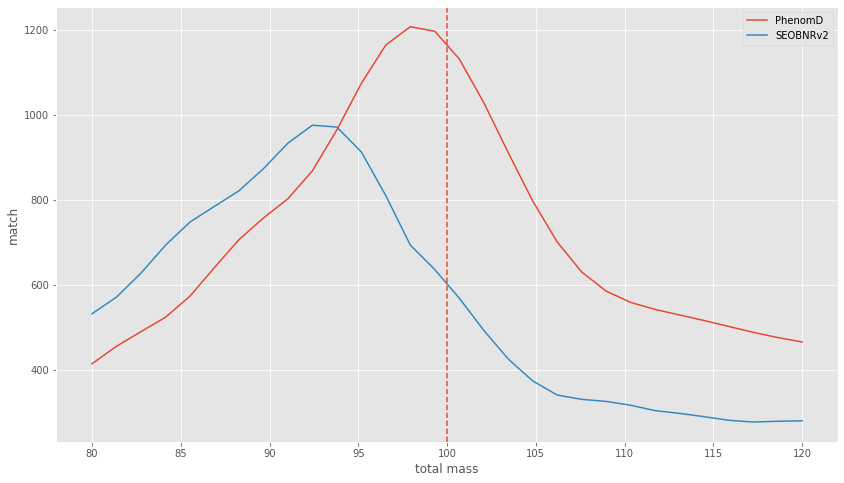

In [21]:
plt.figure(figsize=(14, 8))
plt.plot(mtot_grid, matches2['IMRPhenomD'], label='PhenomD')
plt.plot(mtot_grid, matches2['SEOBNRv2'], label='SEOBNRv2')
plt.axvline(100, ls='--')
plt.legend()
plt.xlabel("total mass")
plt.ylabel("match")

Text(0, 0.5, 'match')

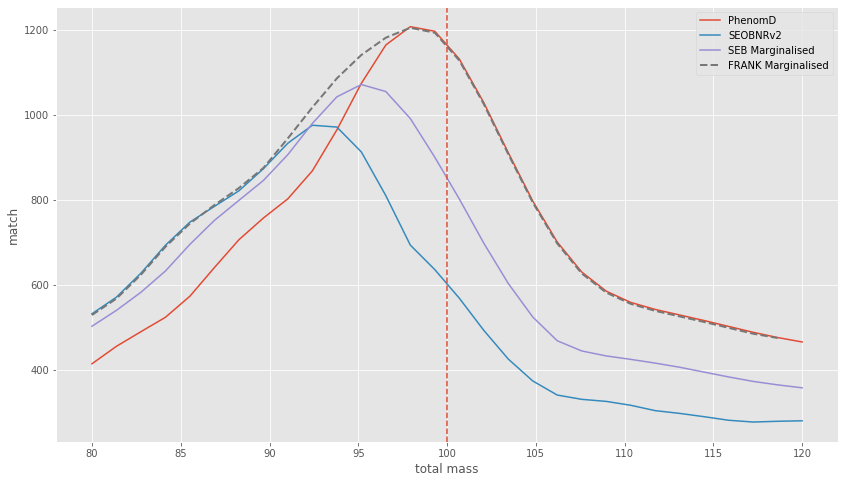

In [27]:
plt.figure(figsize=(14, 8))
plt.plot(mtot_grid, matches2['IMRPhenomD'], label='PhenomD')
plt.plot(mtot_grid, matches2['SEOBNRv2'], label='SEOBNRv2')

plt.plot(mtot_grid, matches_alpha_grid.sum(axis=0)/len(mtot_grid), label='SEB Marginalised')

plt.plot(mtot_grid, res2, label='FRANK Marginalised', lw=2, ls='--')

plt.axvline(100, ls='--')
plt.legend()
plt.xlabel("total mass")
plt.ylabel("match")

In [ ]:
# add in the likelihood weighting to marginalise
# https://arxiv.org/abs/1512.04955